In [1]:
#!pip install dateparser

# ----------------------------------------------
# 1. Cargar librerías
# ----------------------------------------------

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import openai
import time

In [60]:
from openai import OpenAI
import os

# Inicializar cliente con tu API Key (usando variable de entorno)
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

🧪 Verificación rápida

In [61]:
import os
print("OPENAI_API_KEY" in os.environ)

True


# ----------------------------------------------
# 2. Cargar tu archivo original
# ----------------------------------------------

In [62]:
# Asegúrate que tu archivo esté en el mismo directorio
df = pd.read_csv("llm_input_text_dataset_true.csv")  # Debe contener una columna 'text' y 'date'

# Inicializar columnas para los resultados
df["fiscal_risk_score"] = None        # Puntaje del 1 al 5
df["risk_index"] = None               # Normalizado a escala 0.0–1.0

In [63]:
# Asegurar columnas necesarias
assert 'text' in df.columns, "Falta columna 'text' con los párrafos"
assert 'date' in df.columns, "Falta columna 'date' con la fecha del documento"

In [64]:
df.head(20)

,title,doc_type,doc_id,year,date,page,paragraph_id,text,fiscal_risk_score,risk_index
0,Informe CF N° 002-2016 – Opinión del Consejo F...,Informe,2.0,2016,2016-04-15,2,4,"Sin embargo, en relación a las previsiones de ...",None,None
1,Informe CF N° 002-2016 – Opinión del Consejo F...,Informe,2.0,2016,2016-04-15,3,9,"Teniendo en cuenta lo expuesto, el CF opina qu...",None,None
2,Informe CF N° 002-2016 – Opinión del Consejo F...,Informe,2.0,2016,2016-04-15,4,8,"Por otro lado, el CF recomienda que el MMM inc...",None,None
3,Informe CF N° 003-2016 – Opinión del Consejo F...,Informe,3.0,2016,2016-06-23,3,16,"Por último, cabe indicar que el numeral 8.4 de...",None,None
4,Informe CF N° 003-2016 – Opinión del Consejo F...,Informe,3.0,2016,2016-06-23,3,23,El listado con los gobiernos regionales y loc...,None,None
5,Informe CF N° 003-2016 – Opinión del Consejo F...,Informe,3.0,2016,2016-06-23,4,2,"Sin embargo, en relación a los gobiernos regio...",None,None
6,Informe CF N° 003-2016 – Opinión del Consejo F...,Informe,3.0,2016,2016-06-23,4,6,El objetivo de las reglas fiscales establecida...,None,None
7,Informe CF N° 004-2016 – Opinión del Consejo F...,Informe,4.0,2016,2016-08-18,1,11,"En este entorno, la actividad económica local ...",None,None
8,Informe CF N° 004-2016 – Opinión del Consejo F...,Informe,4.0,2016,2016-08-18,3,4,"Por otro lado, luego de un proceso de consolid...",None,None
9,Informe CF N° 006-2016 – Opinión del Consejo F...,Informe,6.0,2016,2016-08-26,6,25,El CF opina que la proyección de ingresos públ...,None,None


In [65]:
df["date"].dtype

dtype('O')

## to date

In [66]:
import pandas as pd

def convert_date_column(df):
    """
    Convierte la columna 'date' a tipo datetime si existe en el DataFrame.
    
    Argumento:
    - df: pandas.DataFrame
    
    Retorna:
    - df: pandas.DataFrame con la columna 'date' convertida, si corresponde.
    """
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    return df


In [67]:
df = convert_date_column(df)

In [68]:
df["date"].dtype

dtype('<M8[ns]')

In [69]:
df.head(10)

,title,doc_type,doc_id,year,date,page,paragraph_id,text,fiscal_risk_score,risk_index
0,Informe CF N° 002-2016 – Opinión del Consejo F...,Informe,2.0,2016,2016-04-15,2,4,"Sin embargo, en relación a las previsiones de ...",None,None
1,Informe CF N° 002-2016 – Opinión del Consejo F...,Informe,2.0,2016,2016-04-15,3,9,"Teniendo en cuenta lo expuesto, el CF opina qu...",None,None
2,Informe CF N° 002-2016 – Opinión del Consejo F...,Informe,2.0,2016,2016-04-15,4,8,"Por otro lado, el CF recomienda que el MMM inc...",None,None
3,Informe CF N° 003-2016 – Opinión del Consejo F...,Informe,3.0,2016,2016-06-23,3,16,"Por último, cabe indicar que el numeral 8.4 de...",None,None
4,Informe CF N° 003-2016 – Opinión del Consejo F...,Informe,3.0,2016,2016-06-23,3,23,El listado con los gobiernos regionales y loc...,None,None
5,Informe CF N° 003-2016 – Opinión del Consejo F...,Informe,3.0,2016,2016-06-23,4,2,"Sin embargo, en relación a los gobiernos regio...",None,None
6,Informe CF N° 003-2016 – Opinión del Consejo F...,Informe,3.0,2016,2016-06-23,4,6,El objetivo de las reglas fiscales establecida...,None,None
7,Informe CF N° 004-2016 – Opinión del Consejo F...,Informe,4.0,2016,2016-08-18,1,11,"En este entorno, la actividad económica local ...",None,None
8,Informe CF N° 004-2016 – Opinión del Consejo F...,Informe,4.0,2016,2016-08-18,3,4,"Por otro lado, luego de un proceso de consolid...",None,None
9,Informe CF N° 006-2016 – Opinión del Consejo F...,Informe,6.0,2016,2016-08-26,6,25,El CF opina que la proyección de ingresos públ...,None,None


# ----------------------------------------------
# 3. Función para obtener score desde GPT (1–5)
# ----------------------------------------------

In [70]:
context = """
Sabemos que desde aproximadamente 2016 el manejo de las finanzas públicas ha mostrado signos crecientes de deterioro. 
La pérdida de disciplina fiscal, la falta de transparencia y el relajamiento de las reglas fiscales han sido temas 
recurrentes en los informes del Consejo. A ello se suma el impacto de la inestabilidad política —con frecuentes cambios 
ministeriales— sobre la capacidad institucional para llevar una política fiscal prudente y sostenible. En este contexto, 
el Consejo ha venido alertando con más frecuencia y firmeza sobre el incumplimiento de metas fiscales, el deterioro del 
balance público, y los riesgos de un endeudamiento creciente y potencialmente insostenible.

Criterios comunes en los informes del Consejo Fiscal (según categoría):

1. Cumplimiento y disciplina fiscal:
(disciplina fiscal, incumplimiento de metas fiscales, relajamiento de reglas fiscales, uso inadecuado del gasto público, desviación del déficit fiscal, deterioro del marco fiscal, flexibilización sin justificación, política fiscal procíclica)

2. Riesgo y sostenibilidad:
(riesgo fiscal, riesgo de sostenibilidad de la deuda, endeudamiento excesivo, dependencia de ingresos extraordinarios, vulnerabilidad fiscal estructural, uso de medidas transitorias o no permanentes, incertidumbre macrofiscal)

3. Gobernanza e institucionalidad:
(transparencia fiscal, calidad del gasto público, incertidumbre institucional, falta de planificación multianual, cambios frecuentes en autoridades económicas, debilitamiento institucional, independencia fiscal comprometida, ausencia de reforma estructural)
"""

    """
    Evalúa un párrafo de un informe fiscal utilizando GPT-4o y asigna un score del 1 al 5
    según el nivel de preocupación o alarma fiscal expresado.

    Returns:
        - int (1 a 5): Score de riesgo fiscal asignado por el modelo
        - None: En caso de error o respuesta inválida
    """

Interpretación:
- 1 = Sin preocupación fiscal (consolidación fiscal sostenida, cumplimiento de metas, transparencia fiscal, calidad del gasto público, planificación multianual)
- 2 = Ligera preocupación (observaciones menores, advertencias marginales, riesgo fiscal potencial, uso de medidas transitorias o ingresos extraordinarios)
- 3 = Neutral (descripción técnica sin énfasis positivo ni negativo, gestión fiscal dentro del marco previsto)
- 4 = Alta preocupación (incumplimiento de metas, flexibilización sin justificación, incertidumbre macrofiscal, debilitamiento institucional)
- 5 = Alarma fiscal (críticas severas, endeudamiento excesivo, deterioro del marco fiscal, independencia fiscal comprometida)

In [71]:
def get_llm_score(text):
    prompt = f"""
Eres un analista técnico del Consejo Fiscal de Perú. Evalúa el siguiente párrafo extraído de un informe técnico del Consejo Fiscal (CF), donde se emite una opinión sobre el desempeño fiscal del Ministerio de Economía y Finanzas (MEF) en cuanto al cumplimiento de las metas fiscales.

Tu tarea es asignar un **puntaje del 1 al 5** según el **nivel de preocupación o alerta fiscal expresado en el texto**.

Interpretación:
- 1 = Sin preocupación fiscal (cumplimiento de metas, transparencia fiscal, planificación multianual)
- 2 = Ligera preocupación (riesgo fiscal potencial, desviación del déficit, dependencia de ingresos extraordinarios)
- 3 = Neutral (descripción técnica, gestión dentro del marco, sin juicio valorativo)
- 4 = Alta preocupación (incumplimiento de metas, relajamiento fiscal, incertidumbre macroeconómica)
- 5 = Alarma fiscal (críticas severas, riesgo de sostenibilidad de la deuda, independencia fiscal comprometida)

Devuelve solo un número del 1 al 5.

Texto:
\"\"\"{text}\"\"\"
""".strip()

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            max_tokens=5,
        )
        result = response.choices[0].message.content.strip()
        if result in {'1', '2', '3', '4', '5'}:
            return int(result)
        else:
            print(f"⚠️ Respuesta inesperada: {result}")
            return None
    except Exception as e:
        print(f"❌ Error: {e}")
        return None


# ----------------------------------------------
# 4. Ejecutar clasificación (con backup y control de crédito)
# ----------------------------------------------

In [72]:
import openai
print(openai.__version__)


1.91.0


In [73]:
from datetime import datetime

start = time.time()

for i, row in df.iterrows():
    if pd.notna(row["fiscal_risk_score"]):
        continue  # Ya procesado

    score = get_llm_score(row["text"])

    # Guardar score
    df.at[i, "fiscal_risk_score"] = score
    df.at[i, "risk_index"] = score / 5 if score else None

    # Backup cada 10 filas
    if i % 10 == 0:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        df.to_csv(f"backup_fiscal_risk_{timestamp}.csv", index=False)
        print(f"💾 Backup guardado en fila {i} - {timestamp}")

    time.sleep(1.2)  # Control para no sobrecargar

end = time.time()
print(f"✅ Proceso completado en {round((end - start)/60, 2)} minutos.")



💾 Backup guardado en fila 0 - 20250716_154742
💾 Backup guardado en fila 10 - 20250716_154800
💾 Backup guardado en fila 20 - 20250716_154818
💾 Backup guardado en fila 30 - 20250716_154836
💾 Backup guardado en fila 40 - 20250716_154853
💾 Backup guardado en fila 50 - 20250716_154913
💾 Backup guardado en fila 60 - 20250716_154931
💾 Backup guardado en fila 70 - 20250716_154948
💾 Backup guardado en fila 80 - 20250716_155039
💾 Backup guardado en fila 90 - 20250716_155057
💾 Backup guardado en fila 100 - 20250716_155117
💾 Backup guardado en fila 110 - 20250716_155138
💾 Backup guardado en fila 120 - 20250716_155155
💾 Backup guardado en fila 130 - 20250716_155213
💾 Backup guardado en fila 140 - 20250716_155232
💾 Backup guardado en fila 150 - 20250716_155251
💾 Backup guardado en fila 160 - 20250716_155311
💾 Backup guardado en fila 170 - 20250716_155327
💾 Backup guardado en fila 180 - 20250716_155345
💾 Backup guardado en fila 190 - 20250716_155405
💾 Backup guardado en fila 200 - 20250716_155422
💾 B

# Guardar resultados completos

In [74]:
df.to_csv("df_fiscal_scored_true.csv", index=False)

In [75]:
df.head(5)

,title,doc_type,doc_id,year,date,page,paragraph_id,text,fiscal_risk_score,risk_index
0,Informe CF N° 002-2016 – Opinión del Consejo F...,Informe,2.0,2016,2016-04-15,2,4,"Sin embargo, en relación a las previsiones de ...",4,0.8
1,Informe CF N° 002-2016 – Opinión del Consejo F...,Informe,2.0,2016,2016-04-15,3,9,"Teniendo en cuenta lo expuesto, el CF opina qu...",1,0.2
2,Informe CF N° 002-2016 – Opinión del Consejo F...,Informe,2.0,2016,2016-04-15,4,8,"Por otro lado, el CF recomienda que el MMM inc...",2,0.4
3,Informe CF N° 003-2016 – Opinión del Consejo F...,Informe,3.0,2016,2016-06-23,3,16,"Por último, cabe indicar que el numeral 8.4 de...",4,0.8
4,Informe CF N° 003-2016 – Opinión del Consejo F...,Informe,3.0,2016,2016-06-23,3,23,El listado con los gobiernos regionales y loc...,3,0.6


# Fleeting inspect

In [76]:
df["fiscal_risk_score"].value_counts(dropna=False).sort_index()

fiscal_risk_score
1     18
2     86
3     34
4    247
5     46
Name: count, dtype: int64

In [77]:
df["risk_index"].describe()

count     431.0
unique      5.0
top         0.8
freq      247.0
Name: risk_index, dtype: float64

# ----------------------------------------------
# 5. Agregar score promedio por fecha
# ----------------------------------------------

# Aggregation

In [78]:
df_doc_avg = df.groupby(['title', 'date']).agg(
    avg_risk_score=('fiscal_risk_score', 'mean'),
    avg_risk_index=('risk_index', 'mean'),
    n_paragraphs=('fiscal_risk_score', 'count')
).reset_index()

In [79]:
df_doc_avg

,title,date,avg_risk_score,avg_risk_index,n_paragraphs
0,Comunicado N° 01-2022-CF Comunicado del Consej...,2022-01-14,5.0,1.0,1
1,Comunicado N° 01-2024-CF – El Consejo Fiscal a...,2024-02-01,3.9,0.78,10
2,Comunicado N° 01-2025-CF – El Consejo Fiscal e...,2025-01-20,3.833333,0.766667,12
3,Comunicado N° 02-2022-CF Comunicado del Consej...,2022-05-24,4.0,0.8,1
4,Comunicado N° 02-2023-CF Comunicado del Consej...,2023-12-12,4.0,0.8,1
...,...,...,...,...,...
63,Informe N° 05-2024-CF – Opinión del Consejo Fi...,2024-08-23,3.73913,0.747826,23
64,Informe N° 06-2021-CF Opinión del Consejo Fisc...,2021-12-20,3.333333,0.666667,6
65,Informe N°002-2019-CF Opinión del Consejo Fisc...,2019-05-21,2.4,0.48,5
66,Informe N°003-2019-CF Opinión del Consejo Fisc...,2019-06-06,2.833333,0.566667,6


In [80]:
df_score_dist = (
    df.pivot_table(index=['title', 'date'], 
                   columns='fiscal_risk_score', 
                   values='text', 
                   aggfunc='count', 
                   fill_value=0)
    .reset_index()
    .rename(columns={1: 'score_1', 2: 'score_2', 3: 'score_3', 4: 'score_4', 5: 'score_5'})
)


In [81]:
df_score_dist

fiscal_risk_score,title,date,score_1,score_2,score_3,score_4,score_5
0,Comunicado N° 01-2022-CF Comunicado del Consej...,2022-01-14,0,0,0,0,1
1,Comunicado N° 01-2024-CF – El Consejo Fiscal a...,2024-02-01,0,1,1,6,2
2,Comunicado N° 01-2025-CF – El Consejo Fiscal e...,2025-01-20,0,0,3,8,1
3,Comunicado N° 02-2022-CF Comunicado del Consej...,2022-05-24,0,0,0,1,0
4,Comunicado N° 02-2023-CF Comunicado del Consej...,2023-12-12,0,0,0,1,0
...,...,...,...,...,...,...,...
63,Informe N° 05-2024-CF – Opinión del Consejo Fi...,2024-08-23,0,4,0,17,2
64,Informe N° 06-2021-CF Opinión del Consejo Fisc...,2021-12-20,0,2,0,4,0
65,Informe N°002-2019-CF Opinión del Consejo Fisc...,2019-05-21,1,2,1,1,0
66,Informe N°003-2019-CF Opinión del Consejo Fisc...,2019-06-06,0,3,1,2,0


In [82]:
score_cols = ['score_1', 'score_2', 'score_3', 'score_4', 'score_5']
df_score_dist[score_cols] = df_score_dist[score_cols].div(df_score_dist[score_cols].sum(axis=1), axis=0)


In [83]:
df_score_dist

fiscal_risk_score,title,date,score_1,score_2,score_3,score_4,score_5
0,Comunicado N° 01-2022-CF Comunicado del Consej...,2022-01-14,0.0,0.000000,0.000000,0.000000,1.000000
1,Comunicado N° 01-2024-CF – El Consejo Fiscal a...,2024-02-01,0.0,0.100000,0.100000,0.600000,0.200000
2,Comunicado N° 01-2025-CF – El Consejo Fiscal e...,2025-01-20,0.0,0.000000,0.250000,0.666667,0.083333
3,Comunicado N° 02-2022-CF Comunicado del Consej...,2022-05-24,0.0,0.000000,0.000000,1.000000,0.000000
4,Comunicado N° 02-2023-CF Comunicado del Consej...,2023-12-12,0.0,0.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...
63,Informe N° 05-2024-CF – Opinión del Consejo Fi...,2024-08-23,0.0,0.173913,0.000000,0.739130,0.086957
64,Informe N° 06-2021-CF Opinión del Consejo Fisc...,2021-12-20,0.0,0.333333,0.000000,0.666667,0.000000
65,Informe N°002-2019-CF Opinión del Consejo Fisc...,2019-05-21,0.2,0.400000,0.200000,0.200000,0.000000
66,Informe N°003-2019-CF Opinión del Consejo Fisc...,2019-06-06,0.0,0.500000,0.166667,0.333333,0.000000


In [84]:
df_doc_summary = pd.merge(df_doc_avg, df_score_dist, on=['title', 'date'])


In [85]:
df_doc_summary

,title,date,avg_risk_score,avg_risk_index,n_paragraphs,score_1,score_2,score_3,score_4,score_5
0,Comunicado N° 01-2022-CF Comunicado del Consej...,2022-01-14,5.0,1.0,1,0.0,0.000000,0.000000,0.000000,1.000000
1,Comunicado N° 01-2024-CF – El Consejo Fiscal a...,2024-02-01,3.9,0.78,10,0.0,0.100000,0.100000,0.600000,0.200000
2,Comunicado N° 01-2025-CF – El Consejo Fiscal e...,2025-01-20,3.833333,0.766667,12,0.0,0.000000,0.250000,0.666667,0.083333
3,Comunicado N° 02-2022-CF Comunicado del Consej...,2022-05-24,4.0,0.8,1,0.0,0.000000,0.000000,1.000000,0.000000
4,Comunicado N° 02-2023-CF Comunicado del Consej...,2023-12-12,4.0,0.8,1,0.0,0.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
63,Informe N° 05-2024-CF – Opinión del Consejo Fi...,2024-08-23,3.73913,0.747826,23,0.0,0.173913,0.000000,0.739130,0.086957
64,Informe N° 06-2021-CF Opinión del Consejo Fisc...,2021-12-20,3.333333,0.666667,6,0.0,0.333333,0.000000,0.666667,0.000000
65,Informe N°002-2019-CF Opinión del Consejo Fisc...,2019-05-21,2.4,0.48,5,0.2,0.400000,0.200000,0.200000,0.000000
66,Informe N°003-2019-CF Opinión del Consejo Fisc...,2019-06-06,2.833333,0.566667,6,0.0,0.500000,0.166667,0.333333,0.000000


# ----------------------------------------------
# 6. Visualizar índice fiscal
# ----------------------------------------------

# CMA

In [86]:
df_doc_summary = df_doc_summary.sort_values("date")

In [87]:
# Calcula la media móvil centrada con ventana de 3 documentos
df_doc_summary["cma_risk_index"] = df_doc_summary["avg_risk_index"].rolling(window=3, center=True).mean()


$$
\text{CMA}_t = \frac{4X_{t-1} + 2X_t + X_{t+1}}{7}
$$

# Áreas apiladas

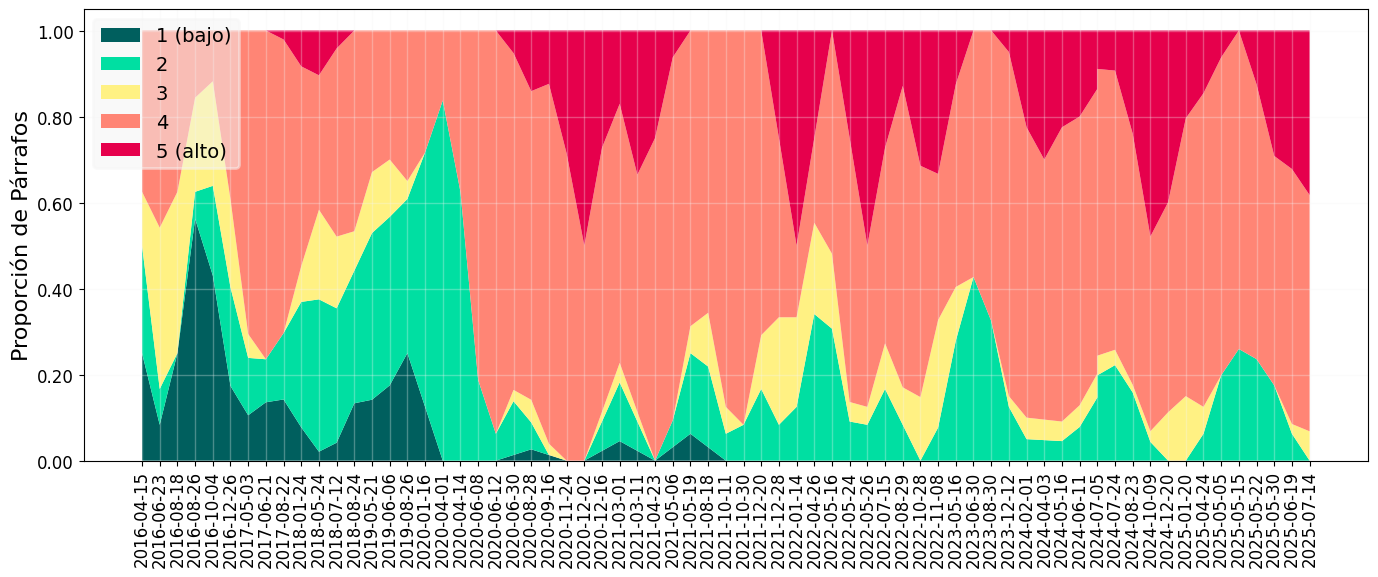

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Asegurar orden por fecha
df_doc_summary = df_doc_summary.sort_values("date").reset_index(drop=True)
df_doc_summary['date_str'] = df_doc_summary['date'].dt.strftime('%Y-%m-%d')

# Pesos del suavizamiento
weights = np.array([1, 2, 1])

# Aplicar CMA con bordes extendidos
for col in ['score_1', 'score_2', 'score_3', 'score_4', 'score_5']:
    series = df_doc_summary[col].copy()

    middle_cma = (
        series.rolling(window=3, center=True)
        .apply(lambda x: np.dot(x, weights) / 4, raw=True)
    )

    # Bordes
    first = series.iloc[0]
    second = series.iloc[1]
    first_smoothed = (3 * first + second) / 4

    last = series.iloc[-1]
    penultimate = series.iloc[-2]
    last_smoothed = (3 * last + penultimate) / 4

    # Insertar bordes
    middle_cma.iloc[0] = first_smoothed
    middle_cma.iloc[-1] = last_smoothed

    df_doc_summary[f'{col}_cma'] = middle_cma

# Configuración para el gráfico
cols_cma = ['score_1_cma', 'score_2_cma', 'score_3_cma', 'score_4_cma', 'score_5_cma']
labels = ['1 (bajo)', '2', '3', '4', '5 (alto)']
colors = ['#005f5e', '#00DFA2', '#FFF183', '#ff8575', '#E6004C']

# Crear figura
fig, ax = plt.subplots(figsize=(14, 6))

# Áreas apiladas suavizadas
ax.stackplot(df_doc_summary['date_str'], 
             *[df_doc_summary[col] for col in cols_cma],
             labels=labels,
             colors=colors)

# Etiquetas
ax.set_ylabel("Proporción de Párrafos", fontsize=16)

# Eje X
ax.tick_params(axis='x', labelrotation=90, labelsize=12)

# Eje Y con 2 decimales
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax.tick_params(axis='y', labelsize=12)

# Rejilla estética
ax.grid(True, color='#f5f5f5', alpha=0.3, linewidth=1)

# Leyenda personalizada
legend = ax.legend(loc='upper left', frameon=True)
legend.get_frame().set_facecolor('#f5f5f5')
legend.get_frame().set_alpha(0.5)
legend.get_frame().set_edgecolor('#f5f5f5')  # contorno sin transparencia
legend.get_frame().set_linewidth(2)  # grosor del contorno

# Margen automático
plt.tight_layout()

# Guardar gráfico
plt.savefig("stacked_areas.png", dpi=300)
plt.show()


# Index

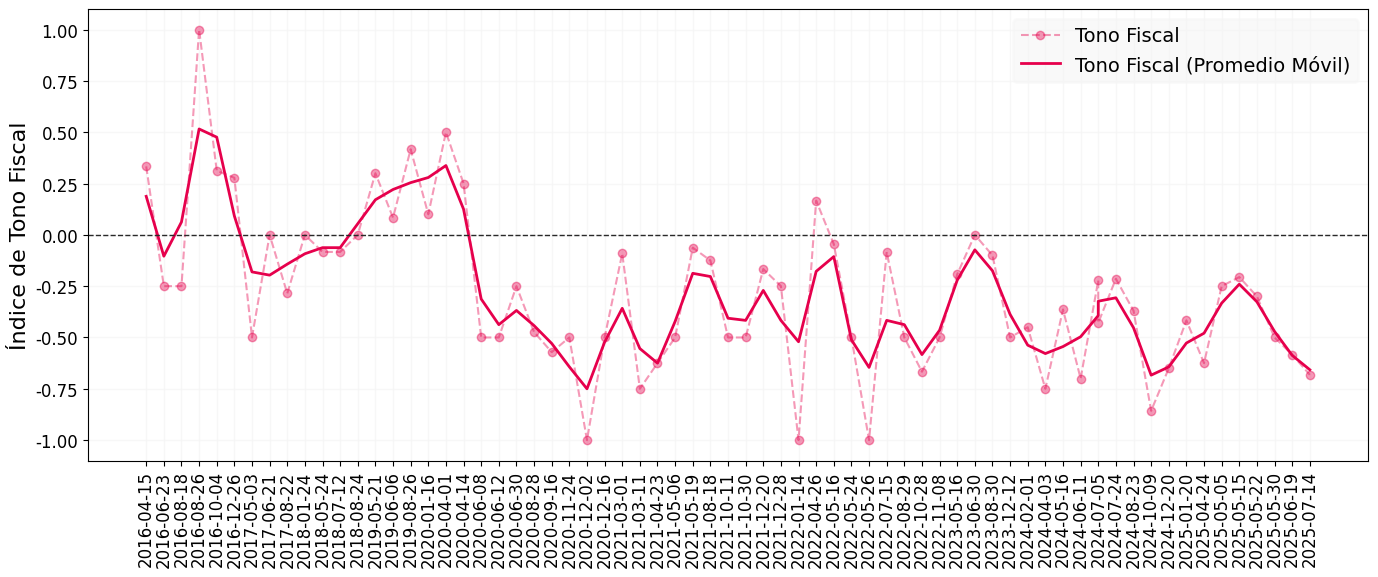

In [142]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Reescalar avg_risk_index desde [0.2, 1.0] a [1, 5]
df_doc_summary["mu_scaled"] = 1 + 4 * (df_doc_summary["avg_risk_index"] - 0.2) / (1.0 - 0.2)

# Calcular índice de tono fiscal
df_doc_summary["fiscal_tone_index"] = (3 - df_doc_summary["mu_scaled"]) / 2

# Suavizamiento CMA (1-2-1)
weights = np.array([1, 2, 1])
series = df_doc_summary["fiscal_tone_index"].copy()

cma = series.rolling(window=3, center=True).apply(lambda x: np.dot(x, weights) / 4, raw=True)
cma.iloc[0] = (3 * series.iloc[0] + series.iloc[1]) / 4
cma.iloc[-1] = (3 * series.iloc[-1] + series.iloc[-2]) / 4

df_doc_summary["fiscal_tone_index_cma"] = cma

# Graficar
fig, ax = plt.subplots(figsize=(14, 6))

# Serie original (transparente)
ax.plot(df_doc_summary["date_str"], df_doc_summary["fiscal_tone_index"],
        label="Tono Fiscal", linestyle='--',
        marker='o', alpha=0.4, color="#E6004C")

# Serie suavizada (principal)
ax.plot(df_doc_summary["date_str"], df_doc_summary["fiscal_tone_index_cma"],
        label="Tono Fiscal (Promedio Móvil)", linewidth=2, color="#E6004C")

# Línea horizontal en 0 (tono neutral)
ax.axhline(0, color='#292929', linestyle='--', linewidth=1)

# Eje Y
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax.tick_params(axis='y', labelsize=12)

# Eje X
ax.tick_params(axis='x', labelrotation=90, labelsize=12)

# Etiqueta eje Y
ax.set_ylabel("Índice de Tono Fiscal", fontsize=16)

# Rejilla estética
ax.grid(True, color='#f5f5f5', alpha=0.75, linewidth=1)

# Leyenda personalizada
legend = ax.legend(loc='upper right', frameon=True)
legend.get_frame().set_facecolor('#f5f5f5')
legend.get_frame().set_alpha(0.5)
legend.get_frame().set_edgecolor('#f5f5f5')  # contorno sin transparencia
legend.get_frame().set_linewidth(2)  # grosor del contorno

# Ajuste final
plt.tight_layout()

# Guardar y mostrar
plt.savefig("fiscal_tone_index.png", dpi=300)
plt.show()

In [93]:
print("Rango de avg_risk_index:", df_doc_summary["avg_risk_index"].min(), "a", df_doc_summary["avg_risk_index"].max())


Rango de avg_risk_index: 0.2 a 1.0
